In [1]:
## reading the images files of train folder

import os
import cv2


path = r"G:\Signature Verification Project\data\sign_data\test"
unique_id = [] ## name or id of each image (same as the id in train_data.csv)
images = [] ## image array

for folder, a, b in os.walk(path):
    for file in b:
        img = cv2.imread(os.path.join(folder, file)) ## reading image as matrix
        
        if img is not None:
            images.append(img)
            
            ## creating  unique id for each image
            if "forg" in str(folder):
                unique_id.append(str(folder[-8:]) + "/" + str(file.lower()))
            else:
                unique_id.append(str(folder[-3:]) + "/" + str(file.lower()))
    

In [2]:
images[0].shape

(323, 670, 3)

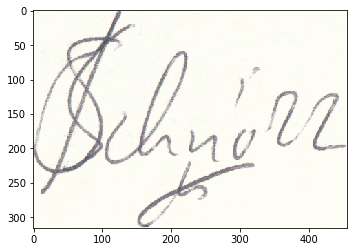

In [3]:
## displaying a raw image

%matplotlib inline

from matplotlib import pyplot as plt


plt.imshow(images[70])
plt.show()

In [4]:
## grayscaling and resizing the images

resized_images = []
dimension = (120, 80) ## new size (width, height)

for img in images:
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ## grayscaling
    
    resized_image = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA) ## resizing
    
    resized_images.append(resized_image)
    

In [5]:
resized_images[0].shape  ## (height, width)

(80, 120)

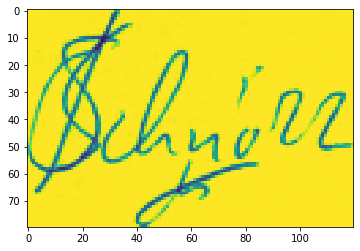

In [6]:
## displaying a resized and grayscaled image

%matplotlib inline

from matplotlib import pyplot as plt


plt.imshow(resized_images[70])
plt.show()

In [7]:
## finding co-ordinates

import numpy as np


height = [] ## Y coordinates in our case 
width = [] ## X coordinates in our case

for image in resized_images:   
    indices = np.where(image!= [0]) ## finds where signature curves lie 
    
    height.append(indices[0])
    width.append(indices[1])

In [8]:
## creating dataframe from above info

import pandas as pd

features_1_df = pd.DataFrame(list(zip(unique_id, width, height)), columns = ["ID", "X", "Y"])

In [9]:
del height

In [10]:
del width

In [11]:
features_1_df.head()

,ID,X,Y
0,049/01_049.png,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,049/02_049.png,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,049/03_049.png,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,049/04_049.png,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,049/05_049.png,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
## exploding X & Y columns of the dataframe

features = features_1_df.set_index('ID').apply(pd.Series.explode).reset_index()


In [13]:
del features_1_df

In [14]:
features.shape

(4800000, 3)

In [15]:
features.head()

,ID,X,Y
0,049/01_049.png,0,0
1,049/01_049.png,1,0
2,049/01_049.png,2,0
3,049/01_049.png,3,0
4,049/01_049.png,4,0


In [16]:
features.isnull().sum(axis = 0)

ID    0
X     0
Y     0
dtype: int64

In [17]:
## finding the position of pen-tip

import math

Xs = features["X"].tolist()
Ys = features["Y"].tolist()

Rs = []

for i in range(len(Xs)):
    Rs.append(math.sqrt(Xs[i]**2 + Ys[i]**2))

features["R"] = Rs ## "R" is the position column

In [18]:
features.head()

,ID,X,Y,R
0,049/01_049.png,0,0,0.0
1,049/01_049.png,1,0,1.0
2,049/01_049.png,2,0,2.0
3,049/01_049.png,3,0,3.0
4,049/01_049.png,4,0,4.0


In [19]:
## angle of "R"

theta = []

for i in range(len(Xs)):
    try:
        theta.append(np.arctan(Ys[i]/Xs[i]))
    except ZeroDivisionError:
        theta.append(0)

features["Angle"] = theta

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in longlong_scalars
  import sys


In [20]:
del Xs, Ys, Rs, theta

In [21]:
features.head()

,ID,X,Y,R,Angle
0,049/01_049.png,0,0,0.0,NaN
1,049/01_049.png,1,0,1.0,0.0
2,049/01_049.png,2,0,2.0,0.0
3,049/01_049.png,3,0,3.0,0.0
4,049/01_049.png,4,0,4.0,0.0


In [22]:
features.Angle.isna().sum(axis = 0)

500

In [23]:
## features.Angle = features.Angle.fillna(0)

In [24]:
## finding change in X direction
features['del_x'] = np.where(features.ID == features.ID.shift(1), features.X.diff(), 0)
features['del_x'] = features.groupby("ID")["del_x"].shift(-1)


## finding change in Y direction
features['del_y'] = np.where(features.ID == features.ID.shift(1), features.Y.diff(), 0)
features['del_y'] = features.groupby("ID")["del_y"].shift(-1)

In [25]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y
0,049/01_049.png,0,0,0.0,NaN,1,0
1,049/01_049.png,1,0,1.0,0.0,1,0
2,049/01_049.png,2,0,2.0,0.0,1,0
3,049/01_049.png,3,0,3.0,0.0,1,0
4,049/01_049.png,4,0,4.0,0.0,1,0


In [26]:
## Magnitude and angle of displacement vector

del_x_l = features.del_x.tolist()
del_y_l = features.del_y.tolist()

disp = [] ## magnitude
disp_theta = [] ## angle

for i in range(len(del_x_l)):
    
    ## magnitude
    disp.append(math.sqrt(del_x_l[i]**2 + del_y_l[i]**2))
    
    ## angle
    try:
        disp_theta.append(np.arctan(del_y_l[i]/del_x_l[i]))
    except ZeroDivisionError:
        disp_theta.append(0)
    
features["displacement"] = disp
features["disp_angle"] = disp_theta

In [27]:
del disp_theta

In [28]:
features[56896:57000]

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle
56896,049/06_049.png,16,74,75.709973,1.357858,1,0,1.000000,0.000000
56897,049/06_049.png,17,74,75.927597,1.344985,1,0,1.000000,0.000000
56898,049/06_049.png,18,74,76.157731,1.332187,1,0,1.000000,0.000000
56899,049/06_049.png,19,74,76.400262,1.319469,1,0,1.000000,0.000000
56900,049/06_049.png,20,74,76.655072,1.306833,1,0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
56995,049/06_049.png,115,74,136.751600,0.571777,1,0,1.000000,0.000000
56996,049/06_049.png,116,74,137.593605,0.567844,1,0,1.000000,0.000000
56997,049/06_049.png,117,74,138.437712,0.563959,1,0,1.000000,0.000000
56998,049/06_049.png,118,74,139.283883,0.560121,1,0,1.000000,0.000000


In [29]:
#features.to_csv(r"G:\Signature Verification Project\data processing\features.csv")

In [ ]:
#import pandas as pd

#features = pd.read_csv(r"G:\Signature Verification Project\data processing\features.csv")

In [ ]:
#features = features.drop(["Unnamed: 0"], axis = 1)

In [ ]:
#del_x_l = features.del_x.tolist()
#del_y_l = features.del_y.tolist()
#disp = features.displacement.tolist()

In [30]:
cos_angle = []
sine_angle = []

for i in range(len(del_x_l)):
    
    ## cosine angle (angle between x-axis and signature curve)
    cos_angle.append((del_x_l[i])/(disp[i]))
    
    ## sine angle (angle between y-axis and signature curve)
    sine_angle.append((del_y_l[i])/(disp[i]))
    
features["cos_angle"] = cos_angle
features["sine_angle"] = sine_angle

In [31]:
del cos_angle, sine_angle, del_x_l, del_y_l, disp

In [32]:
features.columns

Index(['ID', 'X', 'Y', 'R', 'Angle', 'del_x', 'del_y', 'displacement',
       'disp_angle', 'cos_angle', 'sine_angle'],
      dtype='object')

In [33]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,sine_angle
0,049/01_049.png,0,0,0.0,NaN,1,0,1.0,0.0,1.0,0.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,0.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,0.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,0.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,0.0


In [34]:
## finding time
features["Time"] = features.groupby(["ID"]).cumcount()+1

In [35]:
## finding change in Time
features['del_t'] = np.where(features.ID == features.ID.shift(1), features.Time.diff(), 0)
features['del_t'] = features.groupby("ID")["del_t"].shift(-1)

In [36]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,sine_angle,Time,del_t
0,049/01_049.png,0,0,0.0,NaN,1,0,1.0,0.0,1.0,0.0,1,1.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,0.0,2,1.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,0.0,3,1.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,0.0,4,1.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,0.0,5,1.0


In [37]:
del_x_l = features.del_x.tolist()
del_y_l = features.del_y.tolist()
del_t_l = features.del_t.tolist()

vel_x = [] ## velocity in x-direction
vel_y = [] ## velocity in y-direction

for i in range(len(del_x_l)):
    vel_x.append(del_x_l[i]/del_t_l[i])
    vel_y.append(del_y_l[i]/del_t_l[i])
    
features["vel_x"] = vel_x
features["vel_y"] = vel_y

In [38]:
del del_x_l, del_y_l, del_t_l

In [39]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,sine_angle,Time,del_t,vel_x,vel_y
0,049/01_049.png,0,0,0.0,NaN,1,0,1.0,0.0,1.0,0.0,1,1.0,1.0,0.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,0.0,2,1.0,1.0,0.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,0.0,3,1.0,1.0,0.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,0.0,4,1.0,1.0,0.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,0.0,5,1.0,1.0,0.0


In [40]:
res_vel = []  ## resultant velocity 
dir_res_vel = []  ## direction of the resultant velocity

for i in range(len(vel_x)):
    res_vel.append(math.sqrt(vel_x[i]**2 + vel_y[i]**2))
    
    try:
        dir_res_vel.append(np.arctan(vel_y[i]/vel_x[i]))
    except ZeroDivisionError:
        dir_res_vel.append(0)
        
features["res_vel"] = res_vel
features["dir_res_vel"] = dir_res_vel

In [41]:
del vel_x, vel_y, res_vel, dir_res_vel

In [42]:
del_t_l = features.del_t.tolist()

## finding change in displacement angle
features['del_disp_angle'] = np.where(features.ID == features.ID.shift(1), features.disp_angle.diff(), 0)
features['del_disp_angle'] = features.groupby("ID")["del_disp_angle"].shift(-1)
## converting it to list
del_disp_angle = features.del_disp_angle.tolist()

angular_vel = [] ## angular velocity

for i in range(len(del_disp_angle)):
    angular_vel.append(del_disp_angle[i]/del_t_l[i])

features["angular_vel"] = angular_vel

In [43]:
del del_disp_angle, del_t_l, angular_vel

In [44]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,sine_angle,Time,del_t,vel_x,vel_y,res_vel,dir_res_vel,del_disp_angle,angular_vel
0,049/01_049.png,0,0,0.0,NaN,1,0,1.0,0.0,1.0,0.0,1,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,0.0,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,0.0,3,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,0.0,4,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,0.0,5,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [45]:
del_vel_x = features.vel_x.tolist()
del_vel_y = features.vel_y.tolist()
del_t_l = features.del_t.tolist()

acceleration_x = [] ## acceleration in x-dir
acceleration_y = [] ## acceleration in y-dir
res_acceleration = [] ## resultant acceleration

for i in range(len(del_t_l)):
    acceleration_x.append(del_vel_x[i]/del_t_l[i])
    acceleration_y.append(del_vel_y[i]/del_t_l[i])
    
    res_acceleration.append(math.sqrt(acceleration_x[i]**2 + acceleration_y[i]**2))
    
features["acceleration_x"] = acceleration_x
features["acceleration_y"] = acceleration_y
features["res_acceleration"] = res_acceleration

del del_vel_x, del_vel_y, del_t_l, acceleration_x, acceleration_y, res_acceleration

In [46]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,...,del_t,vel_x,vel_y,res_vel,dir_res_vel,del_disp_angle,angular_vel,acceleration_x,acceleration_y,res_acceleration
0,049/01_049.png,0,0,0.0,NaN,1,0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [47]:
angular_vel = features.angular_vel.tolist()
displacement = features.displacement.tolist()
res_acceleration = features.res_acceleration.tolist()

centripetal_accln = [] ## centripetal acceleration
tangential_accln = [] ## tangential acceleration

for i in range(len(angular_vel)):
    centripetal_accln.append((angular_vel[i]**2)*displacement[i])
    
    tangential_accln.append(math.sqrt(res_acceleration[i]**2 - centripetal_accln[i]))
    
features["centripetal_accln"] = centripetal_accln
features["tangential_accln"] = tangential_accln

del angular_vel, res_acceleration, displacement, centripetal_accln, tangential_accln

In [48]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,...,vel_y,res_vel,dir_res_vel,del_disp_angle,angular_vel,acceleration_x,acceleration_y,res_acceleration,centripetal_accln,tangential_accln
0,049/01_049.png,0,0,0.0,NaN,1,0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [49]:
features.columns

Index(['ID', 'X', 'Y', 'R', 'Angle', 'del_x', 'del_y', 'displacement',
       'disp_angle', 'cos_angle', 'sine_angle', 'Time', 'del_t', 'vel_x',
       'vel_y', 'res_vel', 'dir_res_vel', 'del_disp_angle', 'angular_vel',
       'acceleration_x', 'acceleration_y', 'res_acceleration',
       'centripetal_accln', 'tangential_accln'],
      dtype='object')

In [50]:
features = features.drop(["Time", "del_t", "del_disp_angle"], axis = 1)

In [51]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,...,vel_x,vel_y,res_vel,dir_res_vel,angular_vel,acceleration_x,acceleration_y,res_acceleration,centripetal_accln,tangential_accln
0,049/01_049.png,0,0,0.0,NaN,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [52]:
features["Angle"] = features["Angle"].fillna(0)
features["disp_angle"] = features["disp_angle"].fillna(0)
features["dir_res_vel"] = features["dir_res_vel"].fillna(0)

In [53]:
features.head()

,ID,X,Y,R,Angle,del_x,del_y,displacement,disp_angle,cos_angle,...,vel_x,vel_y,res_vel,dir_res_vel,angular_vel,acceleration_x,acceleration_y,res_acceleration,centripetal_accln,tangential_accln
0,049/01_049.png,0,0,0.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,049/01_049.png,1,0,1.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,049/01_049.png,2,0,2.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,049/01_049.png,3,0,3.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,049/01_049.png,4,0,4.0,0.0,1,0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [54]:
features.to_csv(r"G:\Signature Verification Project\data processing\features_final_wo_pressure_test.csv")

In [ ]:
## features = features.interpolate(method = 'linear', axis = 1 , limit_direction = 'both')

In [27]:
import numpy as np

pressure = []

for image in resized_images[2]:
	Image_Height = image.shape[0]
	Image_Width = image.shape[1]
	
	pre = np.zeros([256], np.int32)
	
	for x in range(0, Image_Height):
		for y in range(0, Image_Width):
			pre[image[x,y]] +=1
    
	pressure.append(pre)


IndexError: tuple index out of range

In [15]:
pre.shape

(256,)

In [23]:
resized_images[0].shape[1]

120

In [16]:
pre

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   